# Gaussian process + HMC
Investigations into and implementation of the paper by Rasmussen:

http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/pdfs/pdf2080.pdf


## Gaussian processes
A simple example with the sklearn interface

Prior kernel: 1**2 * RBF(length_scale=10)
MLE kernel  : 4.96**2 * RBF(length_scale=1.8)


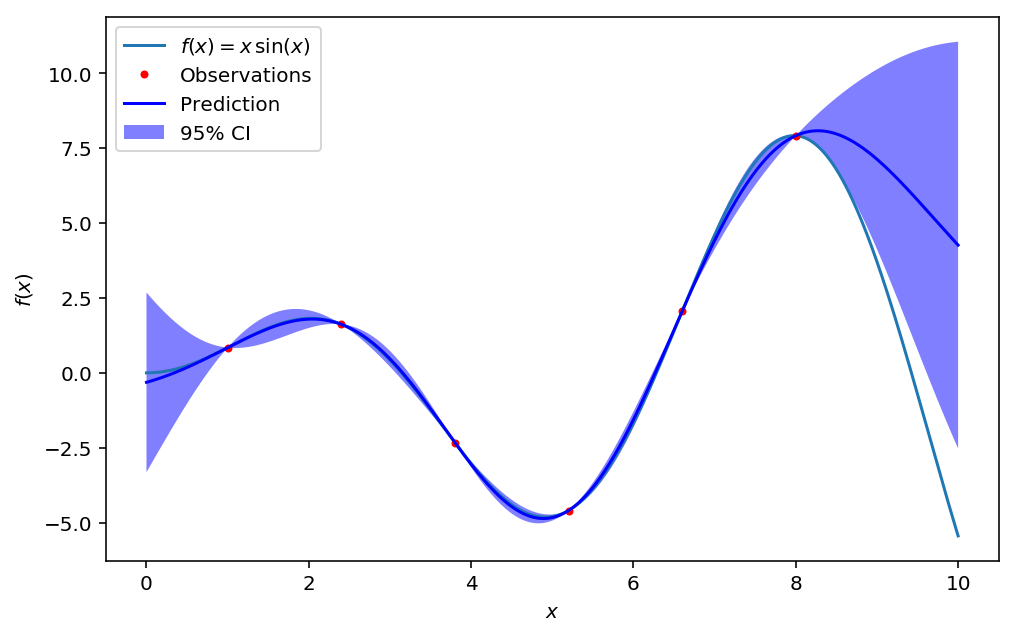

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel


def f_target(x):
    return x * np.sin(x)


def _reshapex(x):
    ''' Reshape an x value to include a second dimension '''
    assert len(x.shape) == 1
    return x.reshape((x.shape[0], 1))


# The points and values which we have sampled
x = np.linspace(1, 8, 6)
y = f_target(x)

# Fit a gaussian process
# The tuples in the arguments to the kernels indicate the valid range of the parameters
# when calling 'fit'
kernel = ConstantKernel(1, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
print('Prior kernel:', kernel)

# n_restarts_optimizer is trying to avoid getting stuck in a local minimum when looking for
# hyperparameter values. If the hyperparameters were set *exactly*, then this could be left
# at the default value, which is 0.
regressor = GaussianProcessRegressor(kernel, n_restarts_optimizer=20)
regressor.fit(_reshapex(x), y)
print('MLE kernel  :', regressor.kernel_)


# Evaluate our GP at many more points - include the uncertainty at every point
x_eval = np.linspace(0, 10, 500)
y_eval, sigma_eval = regressor.predict(_reshapex(x_eval), return_std=True)

plt.figure(figsize=(8, 5))
plt.plot(x_eval, f_target(x_eval), label=r'$f(x) = x\,\sin(x)$')
plt.plot(x, y, 'r.', label='Observations')
plt.plot(x_eval, y_eval, 'b-', label='Prediction')
plt.fill(np.concatenate([x_eval, x_eval[::-1]]),
         np.concatenate([(y_eval - 1.96 * sigma_eval),
                         (y_eval + 1.96 * sigma_eval)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

In order to do HMC on a function, we need to compute derivatives. First let's check that we can map terms from the GP regressor to things that are described in the paper. It looks like "kernel\_" is a callable that computes the covariance function, and "alpha\_" is a constant which corresponds to $C(x, x)^{-1}y$, (where $y$ are the target training values) referring to equation (5) in the paper.

In [3]:
# This is how we get the C(x^*, x) term.
# cov = regressor.kernel_(_reshapex(x_eval), _reshapex(x)).shape

cov_xx = regressor.kernel_(_reshapex(x), _reshapex(x))

# x & y are also available from the regressor as x_train and y_train
alpha2 = np.linalg.inv(cov_xx).dot(y)

# We are just trying to show that these two things are equivalent
print(regressor.alpha_)
print(alpha2)

[-0.09474854  0.1047566   0.35341096 -0.875699    0.45340534  0.2244382 ]
[-0.09474854  0.1047566   0.35341096 -0.875699    0.45340534  0.2244382 ]


Good, so now we need to compute, from equation (7):

$$ \mathbb{E}\left[\frac{\partial y^*}{\partial x^*_d} \right] = \frac{\partial C(x^*, x)}{\partial x^*_d} C(x, x)^{-1} y. $$

In [4]:
from pypuffin.plaintext import instance_to_string

const_kernel = regressor.kernel_.k1
rbf_kernel = regressor.kernel_.k2
print(instance_to_string(const_kernel, include_type_properties=True))
print(instance_to_string(rbf_kernel, include_type_properties=True))

ConstantKernel<
  bounds: array([[-6.90775528,  6.90775528]]),
  constant_value: 24.57818867746359,
  constant_value_bounds: (0.001, 1000.0),
  hyperparameter_constant_value: Hyperparameter(name='constant_value', value_type='numeric', bounds=array([[  1.00000000e-03,   1.00000000e+03]]), n_elements=1, fixed=False),
  hyperparameters: [Hyperparameter(name='constant_value', value_type='numeric', bounds=array([[  1.00000000e-03,   1.00000000e+03]]), n_elements=1, fixed=False)],
  n_dims: 1,
  theta: array([ 3.20185941]),
>
RBF<
  anisotropic: False,
  bounds: array([[-4.60517019,  4.60517019]]),
  hyperparameter_length_scale: Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[  1.00000000e-02,   1.00000000e+02]]), n_elements=1, fixed=False),
  hyperparameters: [Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[  1.00000000e-02,   1.00000000e+02]]), n_elements=1, fixed=False)],
  length_scale: 1.8019384196601342,
  length_scale_bounds: (0.01, 10

In [5]:
print(instance_to_string(regressor))

GaussianProcessRegressor<
  L_: array([[  4.95763943e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.66603603e+00,   3.33741944e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.48238873e+00,   3.81743874e+00,   2.79425729e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.27771404e-01,   1.84200012e+00,   3.81399291e+00,
          2.55563070e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.96299571e-02,   4.43362787e-01,   2.00335579e+00,
          3.79727639e+00,   2.43870973e+00,   0.00000000e+00],
       [  2.62011122e-03,   5.59910491e-02,   5.03656559e-01,
          2.08332602e+00,   3.78478358e+00,   2.37834876e+00]]),
  X_train_: array([[ 1. ],
       [ 2.4],
       [ 3.8],
       [ 5.2],
       [ 6.6],
       [ 8. ]]),
  alpha: 1e-10,
  alpha_: array([-0.09474854,  0.1047566 ,  0.35341096, -0.875699  ,  0.45340534,
        0.2244

/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function rng is deprecated; Attribute rng was deprecated in version 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/home/thomas/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function y_train_mean is deprecated; Attribute y_train_mean was deprecated in version 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
X_eval = _reshapex(x_eval)
X = _reshapex(x)

In [7]:
# This is the different between each evaluation point and each training point, in a vector sense. It is therefore
# a three-component tensor.
# (n_eval, n_train, dim)
x_twiddle = X_eval[:, np.newaxis, :] - X[np.newaxis, :, :]
print(x_twiddle.shape)

# kernel(X_eval, X) --> shape of (n_eval, n_train)
print(rbf_kernel(X_eval, X).shape)

# Therefore the gradient, which looks at the derivative of each component of this covariance matrix to the 
# *corresponding* evaluation vector's coordinates, should have shape
# (n_eval, n_train, dim)
rbf_kernel_derivative = - (1 / rbf_kernel.length_scale ** 2) * x_twiddle * rbf_kernel(X_eval, X)[:, :, np.newaxis]
print(rbf_kernel_derivative.shape)

# Let's just check that this seems like a plausible value for the derivative with a finite-difference approximation
dx = 1e-6
approx_deriv = (rbf_kernel(X_eval + dx, X) - rbf_kernel(X_eval, X)) / dx
print(approx_deriv[0])
print(rbf_kernel_derivative[0].flatten())

(500, 6, 1)
(500, 6)
(500, 6, 1)
[  2.64023949e-01   3.04454216e-01   1.26650021e-01   2.48988619e-02
   2.48266515e-03   1.29272408e-04]
[  2.64024040e-01   3.04454167e-01   1.26649963e-01   2.48988444e-02
   2.48266282e-03   1.29272257e-04]


In [8]:
kernel_derivative = const_kernel.constant_value * rbf_kernel_derivative
print(kernel_derivative.shape)

(500, 6, 1)


This means we have found the term $\frac{\partial C(x^*, x)}{\partial x^*_d}$ All that is left is to multiply through by $\alpha = C(x, x)^{-1} y. $ As seen below, $\alpha$ has shape (n_train,), so we need to broadcast manually in the appropriate directions.

In [9]:
print(regressor.alpha_.shape)

#
gradient = np.sum(kernel_derivative * regressor.alpha_[np.newaxis, :, np.newaxis], axis=1)
gradient_2 = np.tensordot(kernel_derivative, regressor.alpha_, (1, 0))
print(gradient.shape)
print(np.allclose(gradient, gradient_2))

# We should now be the same as using the 'proper' pushed implementation
from pypuffin.sklearn.gaussian_process import gradient_of_mean

gradient_3 = gradient_of_mean(regressor, X_eval)
print(np.allclose(gradient, gradient_3))

(6,)
(500, 1)
True
True


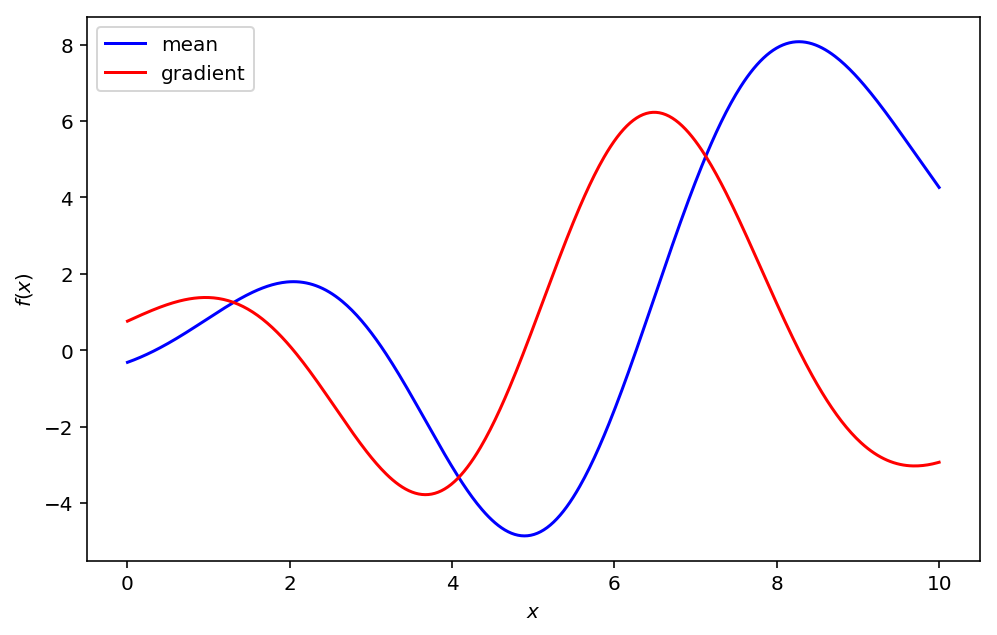

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(x_eval, y_eval, 'b-', label='mean')
plt.plot(x_eval, gradient_3.flatten(), 'r-', label='gradient')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

We also need the derivative of the standard deviation - that's because in the exploratory phase we're going to be performing HMC with the potential function of $\mu - \sigma$, that is saying that very uncertain points are favoured. It seems that, for training points $x$ and kernel $C$, and evaluation points $x^*$, we have a vector of uncertainties at each of the training points $\sigma_i$. The expression for this is as below, where summing is explicit, and greek indices are over the training points; roman over the evaluation points.

$$ \sigma_i = \sqrt{C(x^*, x^*)_{ii} - \sum_{\nu,\,\tau} C(x^*, x)_{i\nu} C^{-1}(x, x)_{\nu\tau} C(x^*, x)_{i\tau}}.  $$

So...
\begin{align}
\frac{\partial \sigma_i}{\partial x^*_d} &= \frac{1}{2\sigma_i} \frac{\partial}{\partial x^*_d} \left( C(x^*, x^*)_{ii} - \sum_{\nu,\,\tau} C(x^*, x)_{i\nu} C^{-1}(x, x)_{\nu\tau} C(x^*, x)_{i\tau} \right) \\
&= \frac{1}{2\sigma_i} \left( 
    \frac{\partial C(x^*, x^*)_{ii}}{\partial x^*_d} -
    2 \sum_{\nu,\,\tau}
        \frac{\partial C(x^*, x)_{i\nu}}{\partial x^*_d} C^{-1}(x, x)_{\nu\tau} C(x^*, x)_{i\tau}
\right).
\end{align}

True


array([ 24.57818868,  24.57818868,  24.57818868,  24.57818868,
        24.57818868,  24.57818868])

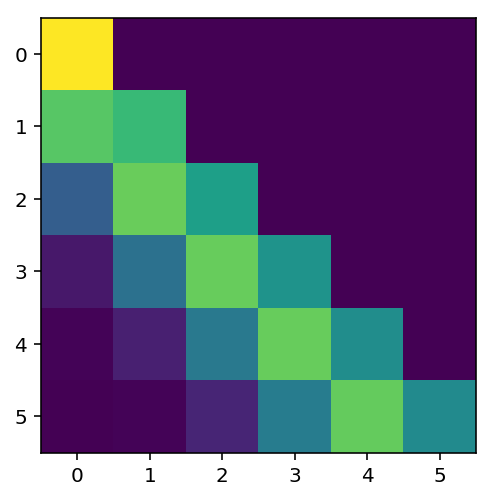

In [11]:
# Notes from looking through the code in GaussianProcessRegressor.predict(..), under the
# 'return_std' block.

# L is some kind of cholesky decomposition I think...
plt.imshow(regressor.L_);

# ... in particular, it is the cholesky decomposition of the covariance of the training points
print(np.allclose(regressor.L_, np.linalg.cholesky(regressor.kernel_(X, X))))

# This is the diagonal of the covariance matrix
regressor.kernel_.diag(X)

In [12]:
from numbers import Real

from pypuffin.decorators import accepts
from pypuffin.types import Callable

@accepts(np.ndarray, np.ndarray, Callable, Callable, eps=Real)
def leapfrog_step(q, p, f_grad_potential, f_grad_kinetic, eps=1e-3):
    ''' Arguments:
            q: ndarray of shape (N,) -- variables of interest
            p: ndarray of shape (N,) -- auxiliary variables
            f_grad_potential: q -> (N,) : gradient of potential wrt. q
            f_grad_kinetic: p -> (N,) : gradient of potential wrt. p
        
        Returns q(t + eps), p(t + eps)
    '''
    p_1 = p - (eps / 2) * f_grad_potential(q)
    q_2 = q + eps * f_grad_kinetic(p_1)
    p_2 = p_1 - (eps / 2) * f_grad_potential(q_2)
    return q_2, p_2

Test the leapfrog integration with a simple graviational potential & kinetic energy term

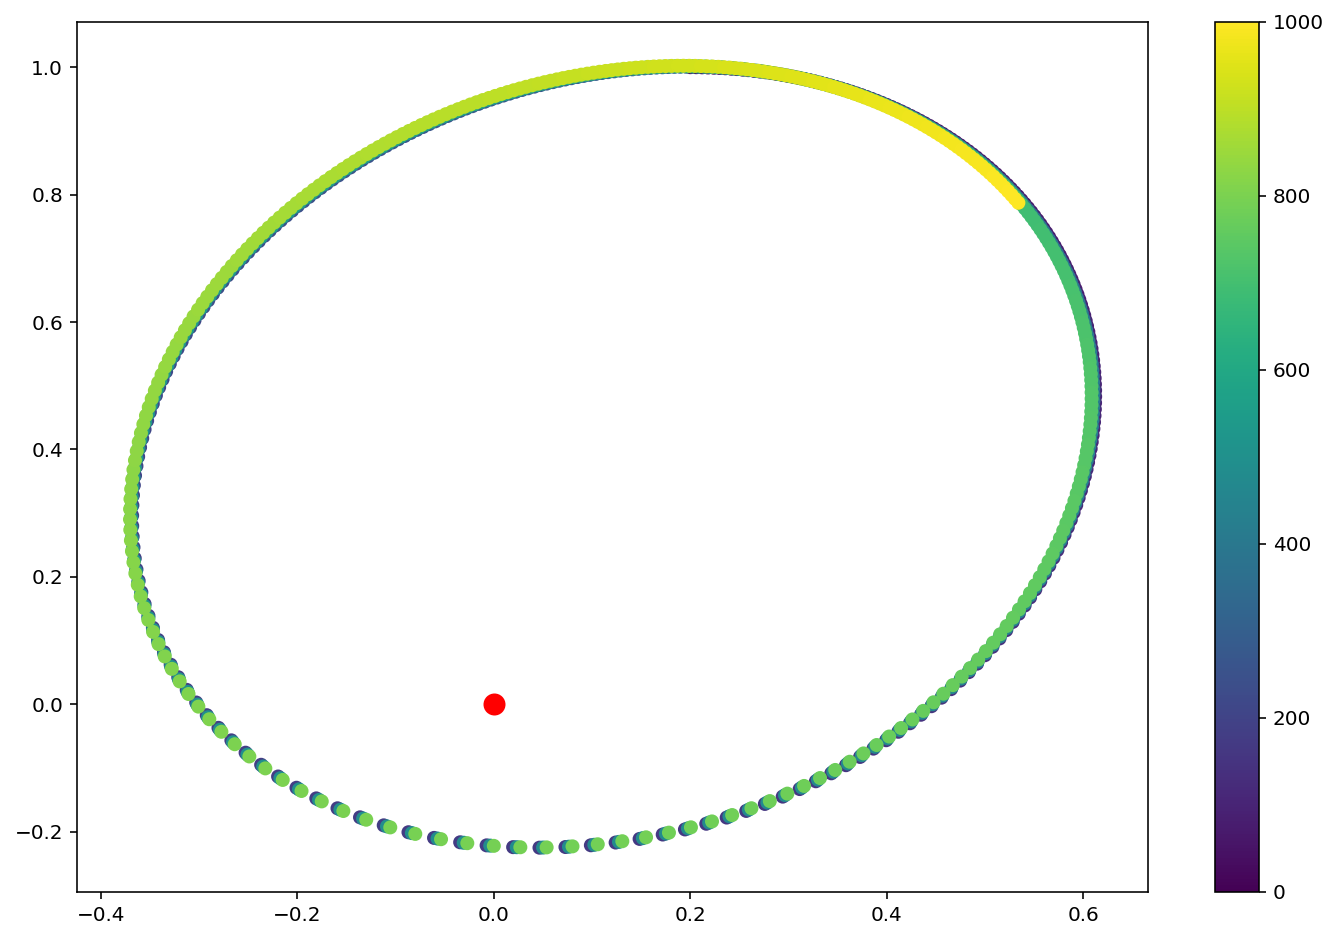

In [13]:
m = 1
f_grad_kinetic = lambda p: p / m
# For inverse square potential
f_grad_potential = lambda q: q * (q.dot(q) ** (- 3 / 2))
eps = 0.01

q_series = [np.asarray([0.2, 1])]
p_series = [np.asarray([0.6, 0])]

for t in range(1000):
    q, p = q_series[-1], p_series[-1]
    q, p = leapfrog_step(q, p, f_grad_potential, f_grad_kinetic, eps=eps)
    q_series.append(q)
    p_series.append(p)

q_t = np.asarray(q_series).T
# plt.plot(q_t[0], q_t[1], '-')
plt.figure(figsize=(12, 8))
plt.scatter(q_t[0], q_t[1], c=np.arange(q_t.shape[1]))
plt.plot([0], [0], 'ro', ms=10)
plt.colorbar();

Good - it seems that we're getting reasonable energy conservation. Now plug in our GP

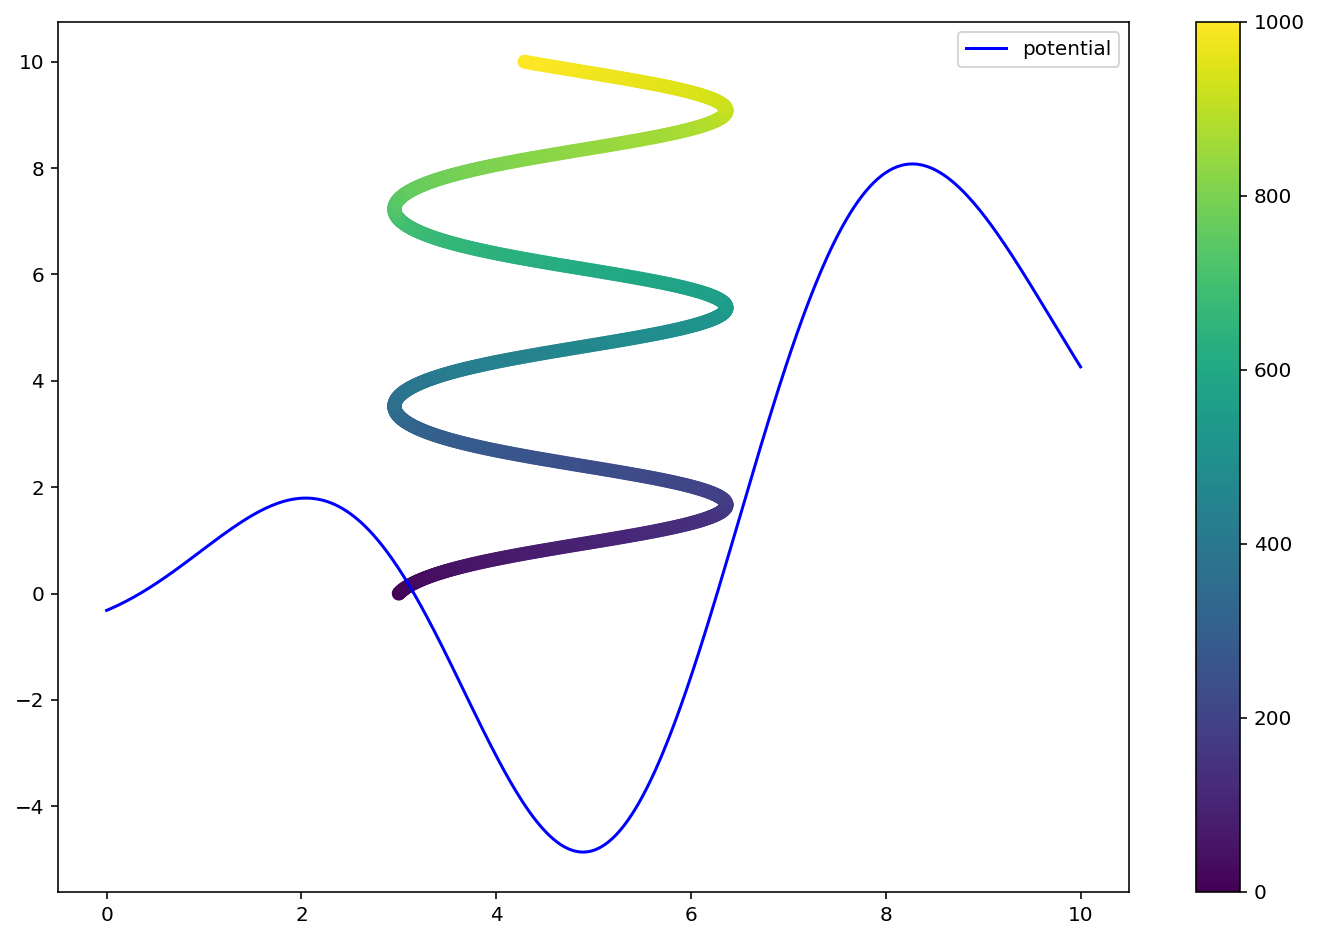

In [14]:
m = 1
f_grad_kinetic = lambda p: p / m
# Use our fitted gp as the potential. Note that it expects to take many
# points at once, so pass a list of length 1, and unpack the result
f_grad_potential = lambda q: gradient_of_mean(regressor, np.asarray([q]))[0]
eps = 0.01

q_series = [np.asarray([3])]
p_series = [np.asarray([0.5])]

for t in range(1000):
    q, p = q_series[-1], p_series[-1]
    q, p = leapfrog_step(q, p, f_grad_potential, f_grad_kinetic, eps=eps)
    q_series.append(q)
    p_series.append(p)

q_t = np.asarray(q_series)
# plt.plot(q_t[0], q_t[1], '-')
plt.figure(figsize=(12, 8))
t = np.arange(q_t.shape[0])
# plt.scatter(q_t[:, 0], regressor.predict(q_t) + 0.01 * t, c=t)
plt.scatter(q_t[:, 0], 0.01 * t, c=t)
plt.plot(x_eval, y_eval, 'b-', label='potential')
plt.colorbar()
plt.legend();

Now do a similar thing, but with the target being $\mu-\sigma$ of the GP prediction.

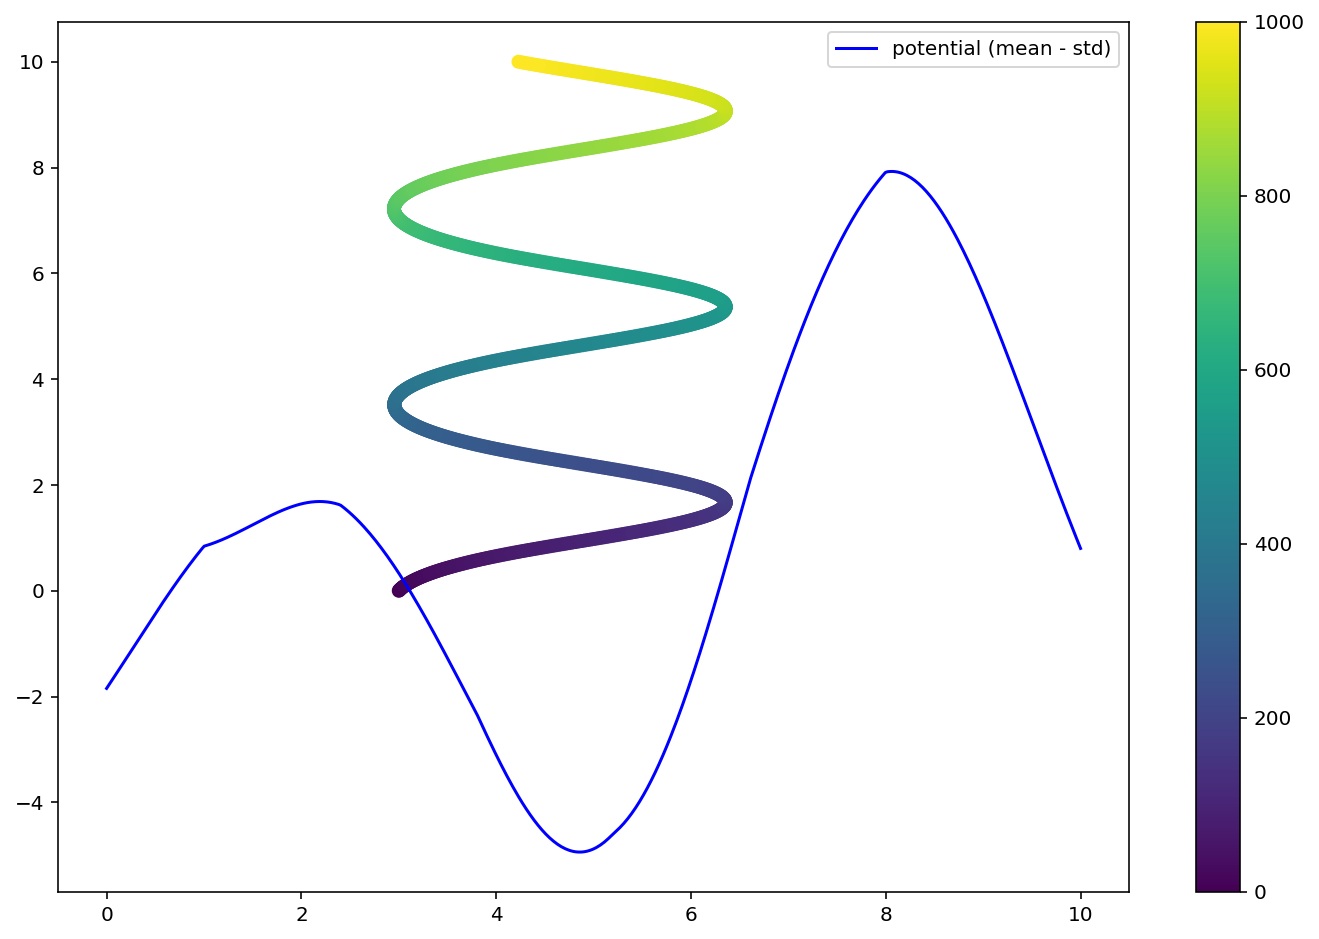

In [21]:
from pypuffin.sklearn.gaussian_process import gradient_of_std

m = 1
f_grad_kinetic = lambda p: p / m
# Use our fitted gp (mu - std) as the potential. Note that it expects to take many
# points at once, so pass a list of length 1, and unpack the result
f_grad_potential = lambda q: (
    gradient_of_mean(regressor, np.asarray([q])) -
    gradient_of_std(regressor, np.asarray([q])))[0]
eps = 0.01

q_series = [np.asarray([3])]
p_series = [np.asarray([0.5])]

for t in range(1000):
    q, p = q_series[-1], p_series[-1]
    q, p = leapfrog_step(q, p, f_grad_potential, f_grad_kinetic, eps=eps)
    q_series.append(q)
    p_series.append(p)

q_t = np.asarray(q_series)
# plt.plot(q_t[0], q_t[1], '-')
plt.figure(figsize=(12, 8))
t = np.arange(q_t.shape[0])
# plt.scatter(q_t[:, 0], regressor.predict(q_t) + 0.01 * t, c=t)
plt.scatter(q_t[:, 0], 0.01 * t, c=t)
plt.plot(x_eval, y_eval - sigma_eval, 'b-', label='potential (mean - std)')
plt.colorbar()
plt.legend();

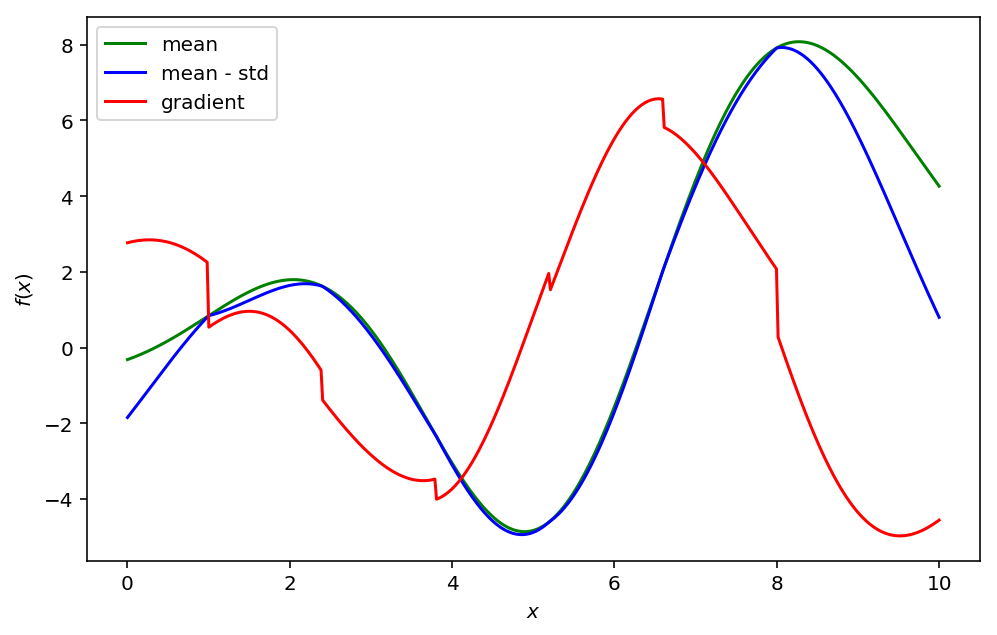

In [27]:
# And for reference, here is the derivative that we're using for (mean - std). It has some interesting discontinuities
plt.figure(figsize=(8, 5))
plt.plot(x_eval, y_eval, 'g-', label='mean')
plt.plot(x_eval, y_eval - sigma_eval, 'b-', label='mean - std')
plt.plot(x_eval, (gradient_of_mean(regressor, X_eval) - gradient_of_std(regressor, X_eval)).flatten(), 
         'r-', label='gradient')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend();

In [19]:
# Performance could be an issue... it's unfortunate that we are effectively calling our
# gradient function, which is efficient when called with large arrays, with single elements
# inside a python loop.
from pypuffin.profile import Profiler, Timer

with Profiler() as profiler, Timer() as timer:
    for t in range(1000):
        q, p = q_series[-1], p_series[-1]
        q, p = leapfrog_step(q, p, f_grad_potential, f_grad_kinetic, eps=eps)
        q_series.append(q)
        p_series.append(p)
print(profiler)
print(timer)

         598007 function calls (586007 primitive calls) in 0.747 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
9000/1000    0.044    0.000    0.746    0.001 /home/thomas/Documents/Programming/pypuffin/pypuffin/decorators.py:177(new_func)
     1000    0.013    0.000    0.697    0.001 <ipython-input-12-84d099e21d30>:6(leapfrog_step)
     2000    0.006    0.000    0.680    0.000 <ipython-input-14-2bfc43df9bd7>:5(<lambda>)
     2000    0.006    0.000    0.605    0.000 /home/thomas/Documents/Programming/pypuffin/pypuffin/sklearn/gaussian_process.py:65(gradient_of_mean)
6000/2000    0.016    0.000    0.537    0.000 /home/thomas/Documents/Programming/pypuffin/pypuffin/sklearn/gaussian_process.py:12(_gradient_kernel)
     2000    0.019    0.000    0.475    0.000 /home/thomas/Documents/Programming/pypuffin/pypuffin/sklearn/gaussian_process.py:51(_gradient_product)
     4000    0.061    0.000    0.256    0.000 /home/thomas/anacon

# TODO
* Implement basic HMC

HMC algorithm - described originally (and well) here:

https://arxiv.org/pdf/1206.1901.pdf